In [57]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

In [175]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
import time
import datetime
from unidecode import unidecode
from dateutil.parser import parse
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse
import pandas as pd
import random
import scipy

BASE_URL = 'https://www.google.com/flights/explore/'


# add wait method to actionchains class
# http://stackoverflow.com/questions/36572190/specify-wait-time-between-actions-when-using-selenium-actionchains
class ActionChains(ActionChains):
    def wait(self, time_s):
        self._actions.append(lambda: time.sleep(time_s))
        return self


# helper function
def setup(start_date, from_place, to_place,city_name):
    """
    used for initializing the start_date and typing from_place, to_place into the search box.

    :param start_date:
    this is a datetime object for the start date that you should use in your query to Google
    Flight explorer.

    :param from_place:
    this is a string with the name of the origin of the flights

    :param to_place:
    this is a string with the name of the regional destination of the flights, e.g. India, South America,
    Scandinavia This is what would be typed into the To field on the Flight Explorer page.

    :param city_name:
    this is a string for the name of the city who's data that you should actually scrape, e.g. Ålesund.

    :return:
    selenium driver, and the index of the target city
    """
    # modify date
    driver = webdriver.Chrome('./chromedriver')
    driver.get(BASE_URL)

    time.sleep(5)

    # input from place
    driver.find_elements_by_css_selector('.LJTSM3-p-a')[0].click()
    ActionChains(driver).wait(2).send_keys(from_place).perform()
    ActionChains(driver).wait(2).send_keys(Keys.ENTER).perform()
    # input to place
    driver.find_elements_by_css_selector('.LJTSM3-p-a')[1].click()
    ActionChains(driver).wait(2).send_keys(to_place).perform()
    ActionChains(driver).wait(2).send_keys(Keys.ENTER).perform()

    time.sleep(4)
    
    start_date = start_date.strftime('%Y-%m-%d')
    URL = driver.current_url[:-10] + start_date
    driver.get(URL)
    
    time.sleep(5)
   
    # find the location of target city
    cities = driver.find_elements_by_css_selector('.LJTSM3-v-c')
    city_names = [unidecode(n.text) for n in cities]
    n_th = None
    for i, name in enumerate(city_names):
        if city_name.lower() in name.lower():
            n_th = i

    return driver, n_th,len(city_names)


# Task #1
def scrape_data(start_date, from_place, to_place, city_name):
    """
    :param start_date: same as above
    :param from_place: same as above
    :param to_place: same as above
    :param city_name: same as above
    :return: a dataframe with 60 rows and with two columns "Date_of_Flight" and "Price."
    """
    driver, n_th,_ = setup(start_date, from_place, to_place,city_name)

    target = driver.find_elements_by_class_name('LJTSM3-v-d')[n_th]
    bars = target.find_elements_by_class_name('LJTSM3-w-x')
    prices = []
    dates = []
    for bar in bars:
        ActionChains(driver).wait(0.01).move_to_element(bar).perform()
        price = driver.find_element_by_class_name('LJTSM3-w-w').text.replace('$','')
        date = driver.find_element_by_class_name('LJTSM3-w-h').text
        prices.append(price)
        dates.append(date)
    df = pd.DataFrame({'Date_of_Flight':dates,'Price':prices})
    driver.quit()
    return df


# Task #2
def scrape_data_90(start_date, from_place, to_place, city_name):
    """
    :param start_date: same as above
    :param from_place: same as above
    :param to_place: same as above
    :param city_name: same as above
    :return: a dataframe with 90 rows and with two columns "Date_of_Flight" and "Price."
    """
    driver,n_th,total = setup(start_date, from_place, to_place,city_name)
    
    target = driver.find_elements_by_class_name('LJTSM3-v-d')[n_th]
    bars = target.find_elements_by_class_name('LJTSM3-w-x')
    prices = []
    dates = []
    for bar in bars:
        ActionChains(driver).wait(0.01).move_to_element(bar).perform()
        price = driver.find_element_by_class_name('LJTSM3-w-w').text.replace('$','')
        date = driver.find_element_by_class_name('LJTSM3-w-h').text
        prices.append(price)
        dates.append(date)
    
    page_down_botton_index = random.choice([x for x in range(total) if x != n_th])
    time.sleep(3)
    driver.find_elements_by_class_name('LJTSM3-w-D')[page_down_botton_index].click()
    time.sleep(3)
    driver.find_elements_by_class_name('LJTSM3-w-D')[page_down_botton_index].click()
    time.sleep(3)

    target = driver.find_elements_by_class_name('LJTSM3-v-d')[n_th]
    bars = target.find_elements_by_class_name('LJTSM3-w-x')
    for bar in bars[:30]:
        ActionChains(driver).wait(0.01).move_to_element(bar).perform()
        price = driver.find_element_by_class_name('LJTSM3-w-w').text.replace('$','')
        date = driver.find_element_by_class_name('LJTSM3-w-h').text
        prices.append(price)
        dates.append(date)
    df = pd.DataFrame({'Date_of_Flight':dates,'Price':prices})
    driver.quit()
    return df

In [176]:
scrape_data_90(datetime.datetime.now(),'london','norway','tromso')

,Date_of_Flight,Price
0,Thu Mar 23 - Tue Mar 28,788
1,Fri Mar 24 - Tue Mar 28,762
2,Sat Mar 25 - Tue Mar 28,615
3,Sun Mar 26 - Fri Mar 31,621
4,Mon Mar 27 - Sat Apr 1,602
5,Tue Mar 28 - Sun Apr 2,438
6,Wed Mar 29 - Sun Apr 2,456
7,Thu Mar 30 - Sun Apr 2,438
8,Fri Mar 31 - Tue Apr 4,373
9,Sat Apr 1 - Tue Apr 4,512


In [177]:
df = _

# analysis

In [179]:
df.Price = df.Price.apply(lambda x: int(x.replace(',','')))
df.Date_of_Flight = df.Date_of_Flight.apply(lambda x: (parse(x.split('-')[0].strip())- parse(df.Date_of_Flight[0].split('-')[0].strip())).days+1)

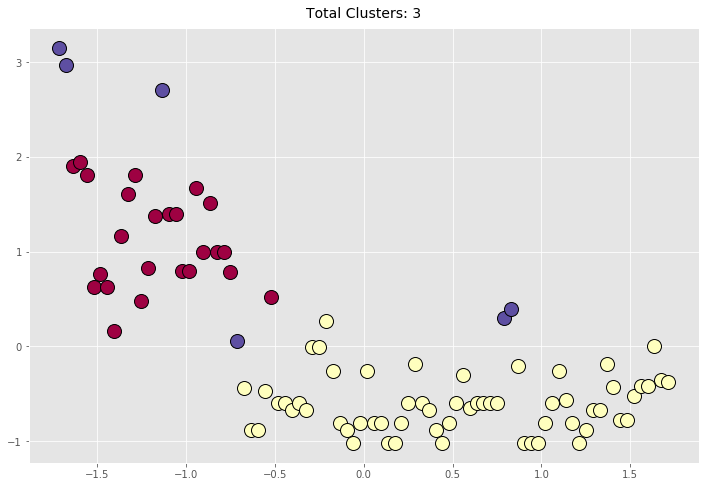

In [189]:
std_encoder = StandardScaler()
std_encoder.fit(df[['Date_of_Flight', 'Price']])
X = std_encoder.transform(df[['Date_of_Flight', 'Price']])

db = DBSCAN(eps=.4, min_samples=4).fit(X)

labels = db.labels_
clusters = len(set(labels))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
 
plt.subplots(figsize=(12,8))
 
for k, c in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=c,
            markeredgecolor='k', markersize=14)
 
plt.title("Total Clusters: {}".format(clusters), fontsize=14, y=1.01)
df['dbscan_labels'] = db.labels_

In [191]:
df.head(3)

,Date_of_Flight,Price,dbscan_labels
0,1,788,-1
1,2,762,-1
2,3,615,0


In [192]:
# find closest cluster
df_encoded = pd.DataFrame(np.concatenate((X,db.labels_.reshape(-1,1)),axis=1))
df_encoded.columns = ['Date_of_Flight','Price','dbscan_labels']
df_encoded.head(5)
df_agged = df_encoded.groupby('dbscan_labels')['Date_of_Flight','Price'].agg(['min','mean','count']).copy()
df_agged

Date_of_Flight                     Price                
                         min      mean count       min      mean count
dbscan_labels                                                         
-1.0               -1.712912 -0.603048     6  0.061978  1.596223     6
 0.0               -1.635927 -1.167603    24  0.162741  1.123893    24
 1.0               -0.673617  0.527346    60 -1.017632 -0.609180    60

In [193]:
lowest_in_outliers = (df_agged.Date_of_Flight.iloc[0,0],df_agged.Price.iloc[0,0])
lowest_in_outliers

(-1.7129115371395962, 0.061977580070830963)

In [194]:
x = df_agged.Date_of_Flight.iloc[1:,1].tolist()
y = df_agged.Price.iloc[1:,1].tolist()
mean_clusters =  [(x,y) for x,y in zip(x,y)]
min_cluster_index = 0 
min_dist = 1000
for i, mean_point in enumerate(mean_clusters):
    dist = scipy.spatial.distance.euclidean(lowest_in_outliers,mean_point)
    if dist < min_dist:
        min_dist = dist
        min_cluster_index = i

In [204]:
# threshold of the closest cluster
df_closest = df[df.dbscan_labels == min_cluster_index]
std = np.std(df_closest.Price)
mean = np.mean(df_closest.Price)
thrhd = max(mean - 2 * std, 50)
df_outliers = df[df.dbscan_labels == -1].copy()
lowest_outlier = df_outliers[df_outliers.Price == df_outliers.Price.min()]

In [214]:
if lowest_outlier.Price.values[0] < thrhd:
    lowest_outlier

In [216]:
lowest_outlier

,Date_of_Flight,Price,dbscan_labels
26,27,359,-1


In [206]:
std_encoder.transform(np.array([0,359]))

/home/yang/miniconda3/envs/chatbot/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([-1.75140393,  0.06197758])

In [ ]:
fig.savefig('task_3_dbscan.png')